In [20]:
import os
import glob
import pathlib
import cv2
import random
from shutil import copyfile
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
p = pathlib.Path('.\\Datasets\\Scene')
image_count = len(list(p.glob('*/*.jpg')))
print("Total Number of Images in the dataset:",image_count)
list(p.glob('*/*.jpg'))[:5]

Total Number of Images in the dataset: 4485


[WindowsPath('Datasets/Scene/00/1.jpg'),
 WindowsPath('Datasets/Scene/00/10.jpg'),
 WindowsPath('Datasets/Scene/00/100.jpg'),
 WindowsPath('Datasets/Scene/00/101.jpg'),
 WindowsPath('Datasets/Scene/00/102.jpg')]

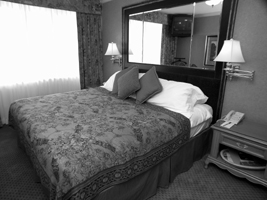

In [22]:
#loading a sample image of Scene-15 dataset
category_0 = list(p.glob('00/*'))       
Image.open(str(category_0[0]))

In [23]:
#Read images from disk using opencv
category_0 = list(p.glob('00/*'))  
img = cv2.imread(str(category_0[0]))

if(len(img.shape)<3):
      print ('gray')
elif len(img.shape)==3:
      print ('Color(RGB)')
else:
      print ('others')
img.shape

Color(RGB)


(200, 267, 3)

In [24]:
# Function for loading and preprocessing images
def image_preprocessing(origin_data_path, out_path):
    
# Loop through each category in the data directory
    for category in os.listdir(origin_data_path):
        category_dir = os.path.join(origin_data_path, category)
        output_dir= os.path.join(out_path, category)
        os.makedirs(output_dir, exist_ok=True)
    # Loop through each image in the category directory
        for filename in os.listdir(category_dir):
            # Read the image
            img_path = os.path.join(category_dir, filename)
            img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
            #Resize the image
            img = cv2.resize(img,(224,224))           
         # Convert the image to RGB format
            if len(img.shape) == 2:
                img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
         # Write the preprocessed image to the output folder
            out_img_path = os.path.join(output_dir,filename)
            cv2.imwrite(out_img_path,img)            

In [25]:
# Create train and test directories for each category
def create_train_test(out_path):  
     
    train_path = "Datasets/Scene/train"
    test_path = "Datasets/Scene/test"
    
    for category in os.listdir(out_path):
        os.makedirs(os.path.join(train_path, category), exist_ok=True)
        os.makedirs(os.path.join(test_path, category), exist_ok=True)        
  # Loop over each category and split the images into train and test sets
    for category in os.listdir(out_path):
        images = os.listdir(os.path.join(out_path, category))
        random.shuffle(images)
        train_images = images[:100]
        test_images = images[100:] 
         # Loop through each image in the category directory
        for img in train_images:
            src = os.path.join(out_path, category, img)
            dst = os.path.join(train_path, category, img)
            copyfile(src, dst)
            
        for img in test_images:
            src = os.path.join(out_path, category, img)
            dst = os.path.join(test_path, category, img)
            copyfile(src, dst)             

In [26]:
# Load the training and testing data 
origin_data_path ="Datasets/Scene/" 
out_path = "Datasets/preprocess/"
#image_preprocessing(origin_data_path, out_path)
#create_train_test(out_path)

image_generator = ImageDataGenerator(
    rescale=1.0/255.0
)
batch_size = 15

generator_train = image_generator.flow_from_directory(
    'Datasets/Scene/train/',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(224,224)
)

generator_test = image_generator.flow_from_directory(
    'Datasets/Scene/test/',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(224,224)
)  

generator_train.image_shape    

Found 1500 images belonging to 15 classes.
Found 2985 images belonging to 15 classes.


(224, 224, 3)

In [27]:
# Define the model architecture
cnn_model = Sequential([
  layers.Conv2D(32,(3,3), padding='same', activation='relu',input_shape=(224,224,3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(128,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(256,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(512,(3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Flatten(),
  layers.Dense(100, activation='relu'),
  Dropout(0.30),
  layers.Dense(15, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
cnn_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model        
cnn_history=cnn_model.fit(generator_train, epochs=2, batch_size=32,validation_data=(generator_test)) 

Epoch 1/2
100/100 [==============================] - 178s 2s/step - loss: 25.3285 - accuracy: 0.0873 - val_loss: 2.7077 - val_accuracy: 0.0389
Epoch 2/2
100/100 [==============================] - 166s 2s/step - loss: 2.7113 - accuracy: 0.0593 - val_loss: 2.7078 - val_accuracy: 0.0871


In [28]:
cnn_history.save('Datasets/models/cnn_model_scene15.h5')

In [29]:
cnn_history.evaluate(generator_test)

199/199 [==============================] - 51s 257ms/step - loss: 2.7078 - accuracy: 0.0871


[2.7078309059143066, 0.08710217475891113]

In [30]:
# Define VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

#Freeze the convolutional layers in the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = false

# Add new classification layers to VGG16 model
vgg16_model = Sequential([
    vgg16_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(15, activation='softmax')
])

# Compile VGG16 model
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train VGG16 model
vgg16_history = vgg16_model.fit(generator_train, epochs=2, batch_size=32, validation_data=(generator_test))

199/199 [==============================] - 51s 253ms/step


array([[0.06520667, 0.06709204, 0.06593613, ..., 0.06691587, 0.06829257,
        0.06661719],
       [0.06520667, 0.06709204, 0.06593613, ..., 0.06691587, 0.06829257,
        0.06661719],
       [0.06520667, 0.06709204, 0.06593613, ..., 0.06691587, 0.06829257,
        0.06661719],
       ...,
       [0.06520668, 0.06709205, 0.06593613, ..., 0.06691588, 0.06829258,
        0.0666172 ],
       [0.06520668, 0.06709205, 0.06593613, ..., 0.06691588, 0.06829258,
        0.0666172 ],
       [0.06520668, 0.06709205, 0.06593613, ..., 0.06691588, 0.06829258,
        0.0666172 ]], dtype=float32)

In [ ]:
# Save the VGG16 Model
vgg16_model.save('Datasets/models/vgg16_model.h5')

In [ ]:
# Plot the accuracy of both models on training and validation data
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Train', 'CNN Val', 'VGG16 Train', 'VGG16 Val'], loc='lower right')
plt.show()

In [ ]:
# Evaluate both models on test data
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(generator_test)
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(generator_test)

print('CNN model test accuracy:', cnn_test_acc)
print('VGG16 model test accuracy:', vgg16_test_acc)